<a href="https://colab.research.google.com/github/omarfathyz8/Teeth-Classification/blob/main/TeethClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Imports

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import tensorflow as tf
from tensorflow.keras import layers
import shutil

## Loading Datasets

#### Drive Mounting

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#### Unzip Dataset Folder

In [ ]:
ZIP_PATH = "/content/drive/MyDrive/CellulaTechnologies/ComputerVision/TeethDataset.zip"
EXTRACT_DIR = "/content/TeethDataset"

In [ ]:
if not os.path.exists(EXTRACT_DIR):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)

In [ ]:
print("Extracted to:", EXTRACT_DIR)

Extracted to: /content/TeethDataset


#### Data Directories

In [ ]:
DATA_DIR = "/content/TeethDataset/Teeth_Dataset"
TRAIN_DIR = os.path.join(DATA_DIR, "Training")
TEST_DIR = os.path.join(DATA_DIR, "Testing")
VAL_DIR = os.path.join(DATA_DIR, 'Validation')

In [ ]:
print('Training classes   :', os.listdir(TRAIN_DIR))
print('Testing classes    :', os.listdir(TEST_DIR))
print('Validation classes :', os.listdir(VAL_DIR))

Training classes   : ['MC', 'OC', 'OLP', 'Gum', 'OT', 'CaS', 'CoS']
Testing classes    : ['output_image.jpg', 'outputs', 'MC', 'OC', 'OLP', 'Gum', 'output', 'OT', 'CaS', 'CoS', 'out']
Validation classes : ['MC', 'OC', 'OLP', 'Gum', 'OT', 'CaS', 'CoS']


#### Remove Extra Classes from Test Folder

In [ ]:
# Allowed class names
allowed_classes = ['MC', 'OC', 'OLP', 'Gum', 'OT', 'CaS', 'CoS']

# Loop through test_dir and remove anything not in allowed_classes
for item in os.listdir(TEST_DIR):
    item_path = os.path.join(TEST_DIR, item)
    if item not in allowed_classes:
        if os.path.isdir(item_path):
            shutil.rmtree(item_path)  # remove folder
        else:
            os.remove(item_path)      # remove file
        print(f"Removed: {item}")

print("\nCleaned test directory successfully.\nClasses now:", os.listdir(TEST_DIR))

Removed: output_image.jpg
Removed: outputs
Removed: output
Removed: out

Cleaned test directory successfully.
Classes now: ['MC', 'OC', 'OLP', 'Gum', 'OT', 'CaS', 'CoS']


## Data Preprocessing

#### Prepare Datasets

In [ ]:
IMG_SIZE = (256, 256) # the images size is already 256*256
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


#### Normalization

In [ ]:
normalization_layer = layers.Rescaling(1/255.0)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

#### Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

In [ ]:
# Apply augmentation only on the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

## Data Visualization

#### Classes Distribution

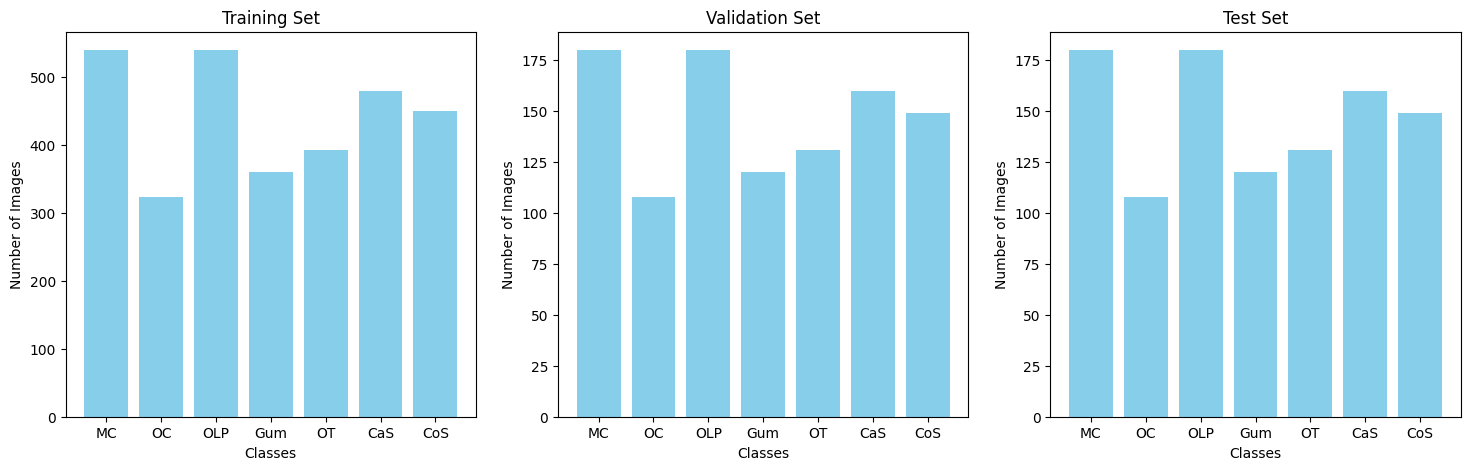

In [ ]:
def count_images_per_class(directory):
    counts = {}
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):   # only count folders
            counts[cls] = len(os.listdir(cls_path))
    return counts

# Count for each split
train_counts = count_images_per_class(TRAIN_DIR)
val_counts   = count_images_per_class(VAL_DIR)
test_counts  = count_images_per_class(TEST_DIR)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, counts, title in zip(axes,
                             [train_counts, val_counts, test_counts],
                             ["Training Set", "Validation Set", "Test Set"]):
    ax.bar(counts.keys(), counts.values(), color="skyblue")
    ax.set_title(title)
    ax.set_xlabel("Classes")
    ax.set_ylabel("Number of Images")

plt.show()

#### Before/After Augmentation

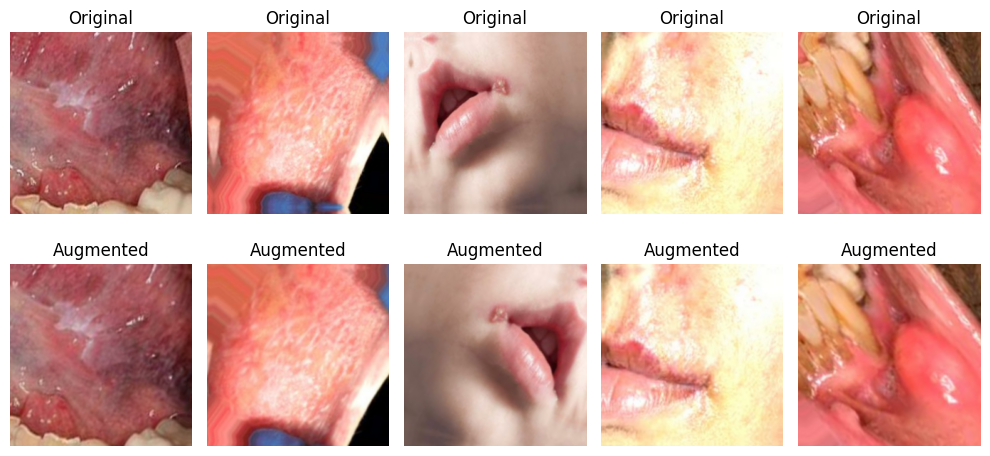

In [ ]:
# Take one batch of normalized (but not augmented) images
for images, labels in train_ds.take(1):
    original_images = images[:5]  # take 5 images
    break

# Apply augmentation to the same images
augmented_images = data_augmentation(original_images, training=True)

# Plot comparison
plt.figure(figsize=(10, 5))
for i in range(5):
    # Original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow((original_images[i].numpy() * 255).astype("uint8"))
    plt.title("Original")
    plt.axis("off")

    # Augmented
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow((augmented_images[i].numpy() * 255).astype("uint8"))
    plt.title("Augmented")
    plt.axis("off")

plt.tight_layout()
plt.show()